In [3]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from matplotlib.patches import Rectangle, FancyBboxPatch
import matplotlib.colors as mcolors
%matplotlib inline

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



In [4]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            self.world = np.full((self.world_height, self.world_width), '', dtype='<U1')
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """ 
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True
        
        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True
        
        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info

    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1
        
        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1
                    
        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]] not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

Here is one example random agent class:

In [74]:
class RandomAgent:
    def __init__(self, env, num_episodes):
        self.action_space = [1, 2, 3, 4]
        self.env = env
        self.num_episodes = num_episodes

    def act(self):
        """Returns a random choice of the available actions"""
        return np.random.choice(self.action_space)

    def learn(self):
        rewards = []
        
        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                action = self.act() 
                next_state, reward, done, info = self.env.step(action)
                cumulative_reward += reward
                state = next_state
            rewards.append(cumulative_reward)

        return rewards

You need to complete the learn() method of the following class to implement your RL algorithm.

In [5]:
# class RLAgent:
#     def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
#         self.action_space = env.action_space
#         self.q_table = dict() # Store all Q-values in a dictionary
#         # Loop through all possible grid spaces, create sub-dictionary for each
#         for agent_x in range(env.world_height):
#             for agent_y in range(env.world_width):
#                 for box_x in range(env.world_height):
#                     for box_y in range(env.world_width):
#                         # Populate sub-dictionary with zero values for possible moves
#                         self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}

#         self.env = env
#         self.num_episodes = num_episodes
#         self.epsilon = epsilon
#         self.alpha = alpha
#         self.gamma = gamma
        
#         # For tracking cliff fall-off rates
#         self.cliff_fall_records = defaultdict(list)
        
#     def act(self, state, is_training=True):
#         """Returns the (epsilon-greedy) optimal action from Q-Value table."""
#         if np.random.uniform(0,1) < self.epsilon and is_training:
#             action = self.action_space[np.random.randint(0, len(self.action_space))]
#         else:
#             q_values_of_state = self.q_table[state]
#             maxValue = max(q_values_of_state.values())
#             action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
#         return action

#     def learn(self):
#         """Updates Q-values iteratively using Q-learning."""
#         rewards = []
#         episode_cliff_falls = []  # Track cliff falls per episode
        
#         for episode in range(self.num_episodes):
#             cumulative_reward = 0
#             state = self.env.reset()
#             state_tuple = state  # state is already a tuple of positions
#             done = False
#             episode_cliff_cells = set()  # Track which cliff cells caused failures in this episode
            
#             while not done:
#                 action = self.act(state_tuple)
#                 next_state, reward, done, info = self.env.step(action)
#                 next_state_tuple = next_state
                
#                 # Convert positions to check for cliff falls
#                 agent_pos = np.array(next_state[:2])
#                 box_pos = np.array(next_state[2:])
                
#                 # Check if episode ended due to cliff fall
#                 if done and reward < -500:  # Cliff fall gives -1000 reward
#                     if self.env._check_off_cliff(agent_pos):
#                         episode_cliff_cells.add(tuple(agent_pos))
#                     if self.env._check_off_cliff(box_pos):
#                         episode_cliff_cells.add(tuple(box_pos))
                
#                 # Q-learning update
#                 current_q = self.q_table[state_tuple][action]
#                 next_max_q = max(self.q_table[next_state_tuple].values())
                
#                 # Update Q-value
#                 new_q = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)
#                 self.q_table[state_tuple][action] = new_q
                
#                 cumulative_reward += reward
#                 state_tuple = next_state_tuple
            
#             rewards.append(cumulative_reward)
#             episode_cliff_falls.append(episode_cliff_cells)
            
#             # Decay epsilon to reduce exploration over time
#             if episode % 1000 == 0 and episode > 0:
#                 self.epsilon *= 0.995
        
#         # Process cliff fall records for analysis
#         self._process_cliff_falls(episode_cliff_falls)
        
#         return rewards
    

class RLAgent:
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space
        self.q_table = dict()
        # Initialize Q-table with all possible states
        for agent_x in range(env.world_height):
            for agent_y in range(env.world_width):
                for box_x in range(env.world_height):
                    for box_y in range(env.world_width):
                        self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}

        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
        # Enhanced cliff fall tracking
        self.cliff_fall_records = defaultdict(lambda: defaultdict(int))
        self.episode_success = []
        
    def act(self, state, is_training=True):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        if np.random.uniform(0,1) < self.epsilon and is_training:
            action = np.random.choice(self.action_space)
        else:
            q_values_of_state = self.q_table[state]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action

    def learn(self):
        """Updates Q-values iteratively using Q-learning with enhanced tracking."""
        rewards = []
        
        for episode in range(self.num_episodes):
            cumulative_reward = 0
            state = self.env.reset()
            state_tuple = state
            done = False
            episode_cliff_cells = set()
            
            while not done:
                action = self.act(state_tuple)
                next_state, reward, done, info = self.env.step(action)
                next_state_tuple = next_state
                
                # Track cliff falls
                agent_pos = np.array(next_state[:2])
                box_pos = np.array(next_state[2:])
                
                if done and reward < -500:  # Cliff fall
                    if self.env._check_off_cliff(agent_pos):
                        episode_cliff_cells.add(tuple(agent_pos))
                    if self.env._check_off_cliff(box_pos):
                        episode_cliff_cells.add(tuple(box_pos))
                
                # Q-learning update
                current_q = self.q_table[state_tuple][action]
                next_max_q = max(self.q_table[next_state_tuple].values())
                new_q = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)
                self.q_table[state_tuple][action] = new_q
                
                cumulative_reward += reward
                state_tuple = next_state_tuple
            
            rewards.append(cumulative_reward)
            self.episode_success.append(1 if cumulative_reward > 0 else 0)
            
            # Record cliff falls by training phase
            phase = min(episode // (self.num_episodes // 10), 9)
            for cliff_cell in episode_cliff_cells:
                self.cliff_fall_records[phase][cliff_cell] += 1
            
            # Decay epsilon
            if episode % 1000 == 0 and episode > 0:
                self.epsilon *= 0.995
        
        return rewards

    def _process_cliff_falls(self, episode_cliff_falls):
        """Process cliff fall records for the heatmap analysis."""
        num_phases = 10
        episodes_per_phase = self.num_episodes // num_phases
        
        for phase in range(num_phases):
            start_ep = phase * episodes_per_phase
            end_ep = (phase + 1) * episodes_per_phase
            
            phase_falls = defaultdict(int)
            total_episodes_in_phase = 0
            
            for ep_idx in range(start_ep, min(end_ep, len(episode_cliff_falls))):
                total_episodes_in_phase += 1
                for cliff_cell in episode_cliff_falls[ep_idx]:
                    phase_falls[cliff_cell] += 1
            
            # Convert to fractions
            for cliff_cell in phase_falls:
                phase_falls[cliff_cell] /= total_episodes_in_phase
            
            self.cliff_fall_records[phase] = phase_falls

    



Here is the game interface where you can manually move the agent.

In [88]:
env = CliffBoxGridWorld(render=True)
env.reset()
env.print_world()
done = False
rewards = []

while not done:
    action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_' '_' 'x' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' '_' '_' '_' '_' 'x' 'x' '_']
 ['_' 'B' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' 'G']
 ['A' '_' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' '_']]
step: 1, state: (5, 1, 4, 1), actions: 4, reward: -14
Action: 4
[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_' '_' 'x' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' '_' '_' '_' '_' 'x' 'x' '_']
 ['_' 'B' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' 'G']
 ['_' 'A' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' '_']]
step: 2, state: (4, 1, 3, 1), actions: 1, reward: -15
Action: 1
[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_

Example code to step random agent in the environment.

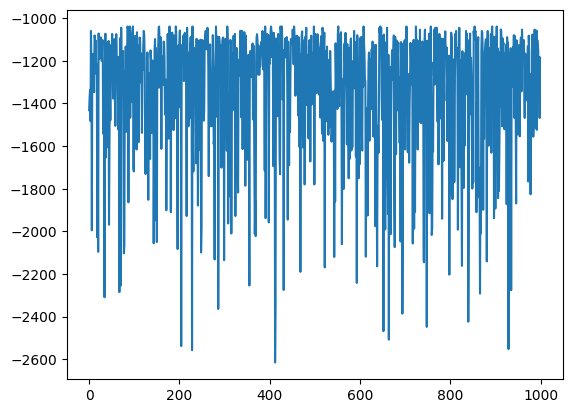

In [87]:
#Initialize the environment and agent
env = CliffBoxGridWorld()
agent = RandomAgent(env, num_episodes=1000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)

Train your own agent!

Success rate: 0.637


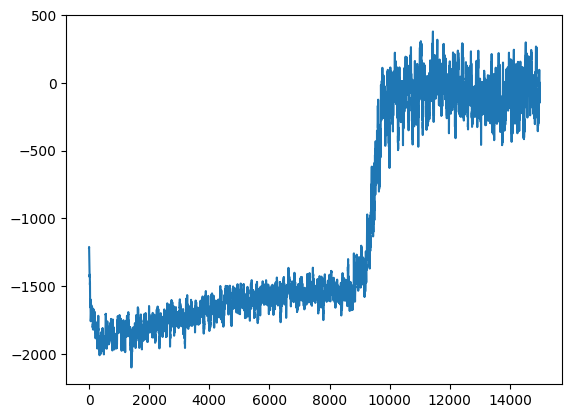

In [78]:
env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=15000)
rewards = agent.learn()

# Calculate success rate
final_rewards = np.array(rewards[-2000:])
success_rate = np.sum(final_rewards > 0) / len(final_rewards)
print(f"Success rate: {success_rate}")

# Smooth plot
weight=0.95
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.plot(smoothed)

You need to complete the following method to visualize your training results.

Training Q-learning agent...


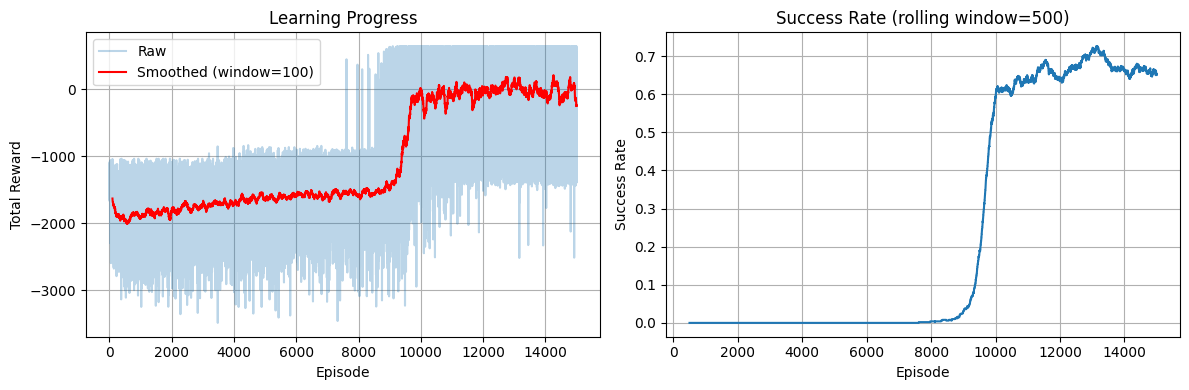

Final success rate: 0.666

Visualizing learned policy...
State space size: 7056

Top 20 states by value:
State (2, 13, 3, 13): Value = 998.00, Policy = 2
State (1, 13, 2, 13): Value = 985.02, Policy = 2
State (1, 13, 3, 13): Value = 984.91, Policy = 2
State (0, 13, 1, 13): Value = 971.17, Policy = 2
State (0, 13, 2, 13): Value = 971.17, Policy = 2
State (0, 12, 1, 13): Value = 956.46, Policy = 4
State (0, 12, 2, 13): Value = 956.21, Policy = 4
State (1, 12, 1, 13): Value = 940.89, Policy = 1
State (0, 11, 1, 13): Value = 940.83, Policy = 4
State (1, 12, 2, 13): Value = 938.31, Policy = 1
State (1, 11, 1, 12): Value = 926.48, Policy = 4
State (1, 11, 1, 13): Value = 926.44, Policy = 4
State (1, 10, 1, 11): Value = 911.22, Policy = 4
State (0, 11, 1, 12): Value = 911.21, Policy = 2
State (2, 11, 1, 12): Value = 911.12, Policy = 1
State (1, 10, 1, 12): Value = 911.11, Policy = 4
State (1, 9, 1, 10): Value = 895.11, Policy = 4
State (2, 10, 1, 11): Value = 895.07, Policy = 1
State (1, 9, 1

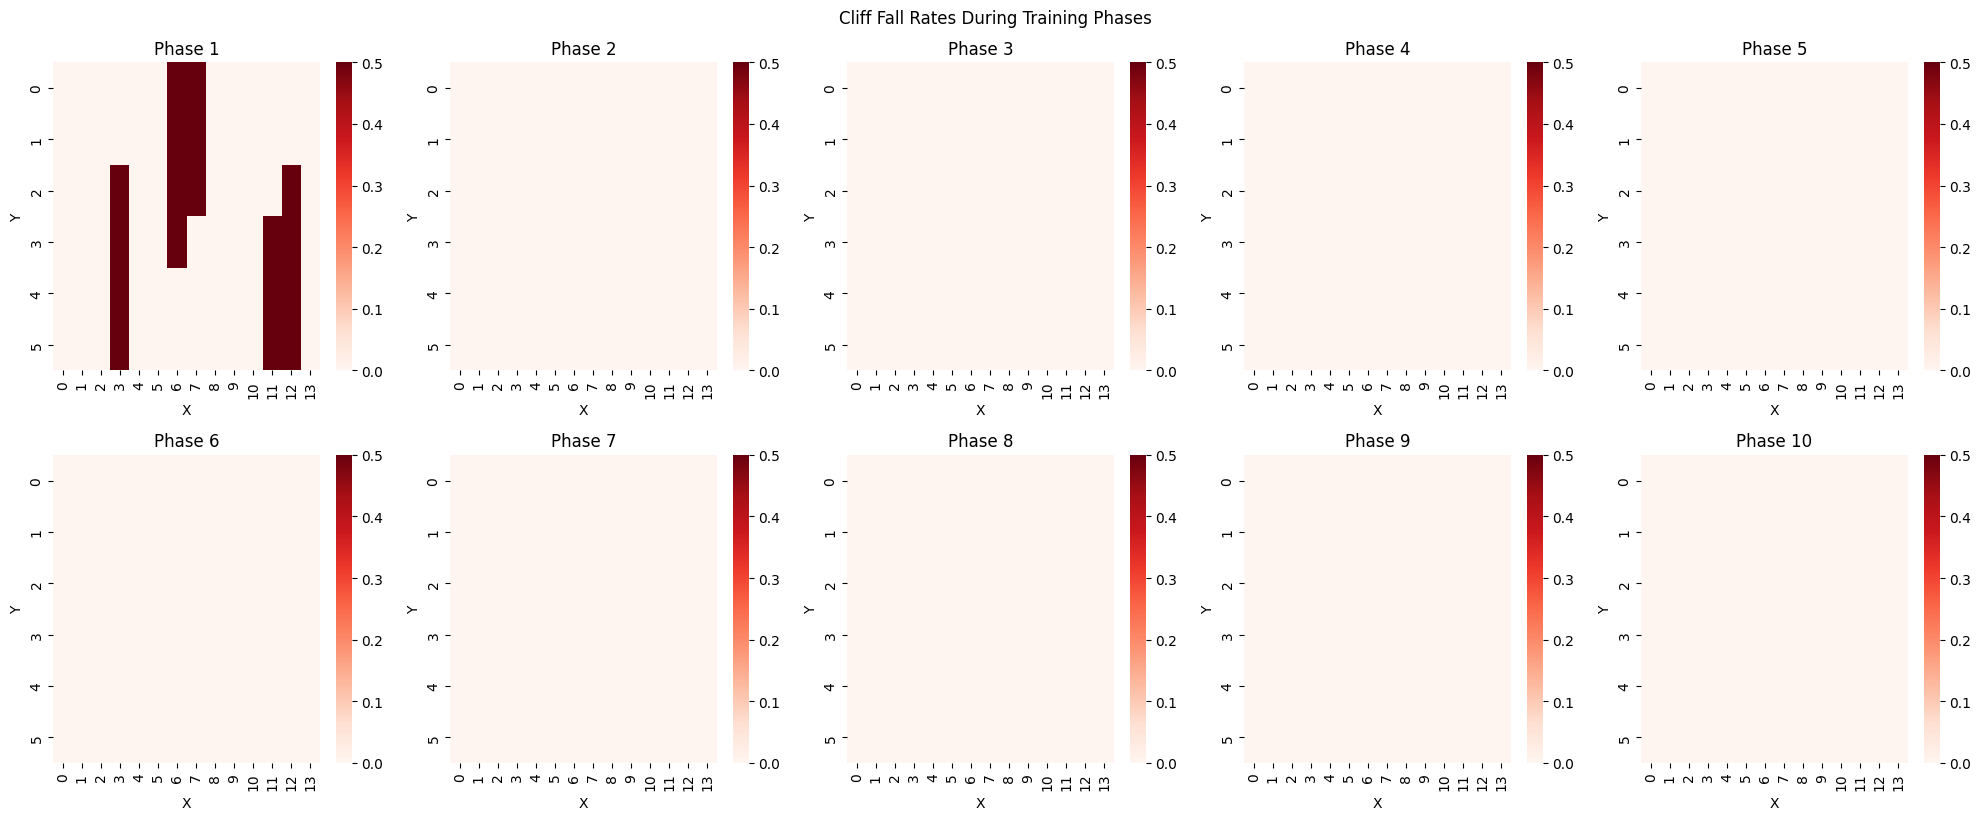


🎯 Analyzing learned policy and values...


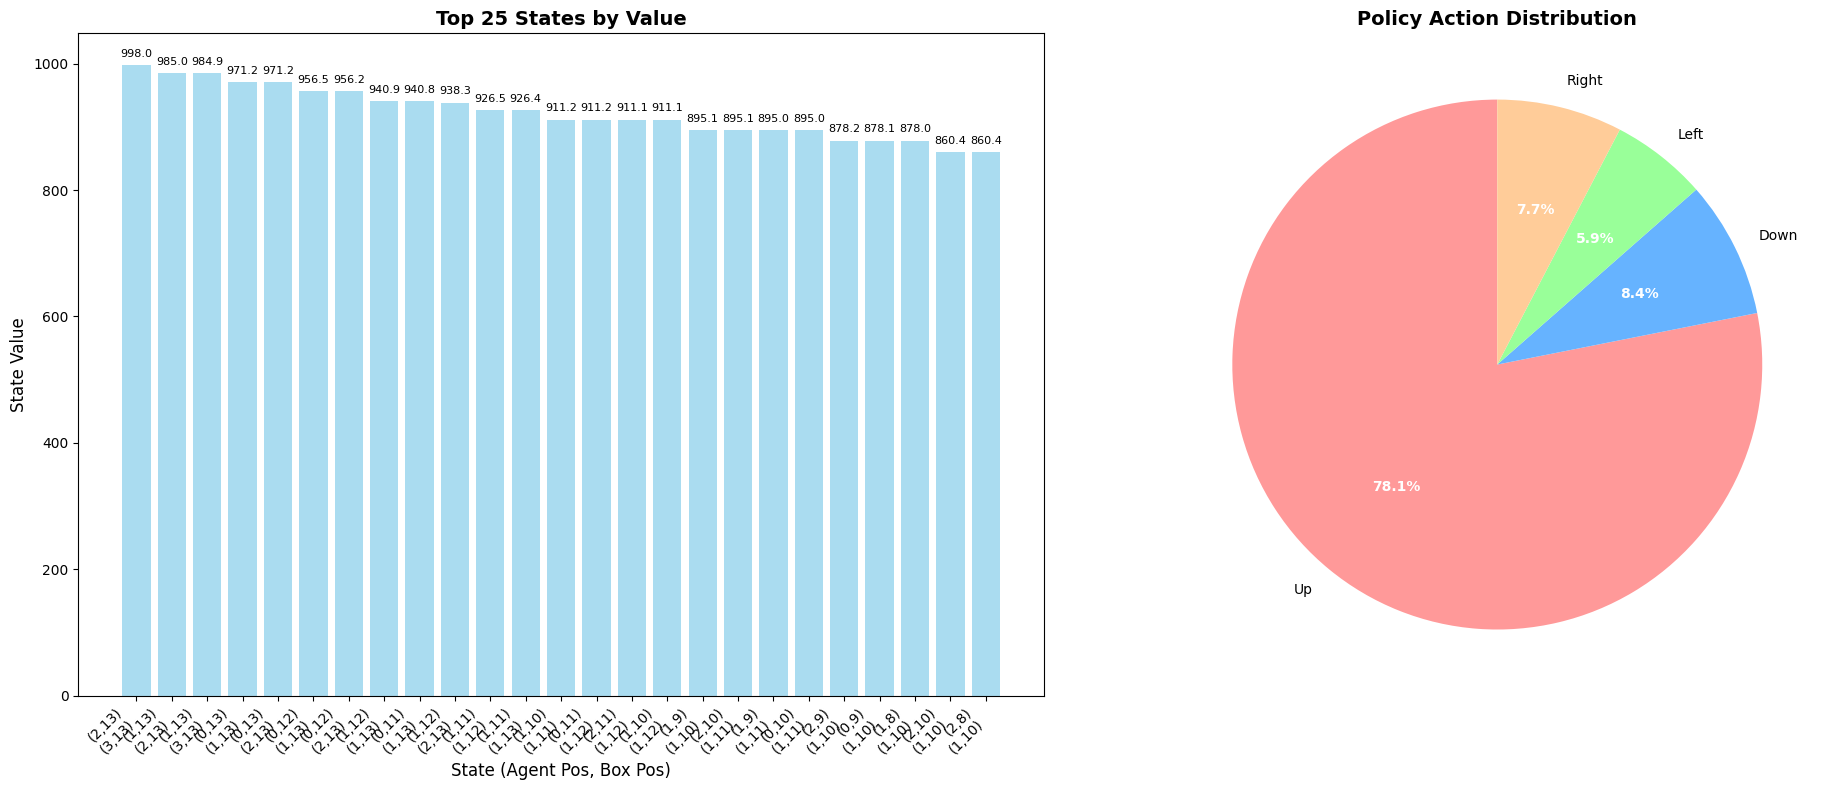

POLICY AND VALUE ANALYSIS
Total states: 7,056
Average state value: -13.46
Maximum state value: 998.00
Minimum state value: -287.04

Top 10 Most Valuable States:
Rank | State (Agent, Box) | Value | Best Action
-------------------------------------------------------
   1 | ( 2,13) ( 3,13) |  998.0 | Down
   2 | ( 1,13) ( 2,13) |  985.0 | Down
   3 | ( 1,13) ( 3,13) |  984.9 | Down
   4 | ( 0,13) ( 1,13) |  971.2 | Down
   5 | ( 0,13) ( 2,13) |  971.2 | Down
   6 | ( 0,12) ( 1,13) |  956.5 | Right
   7 | ( 0,12) ( 2,13) |  956.2 | Right
   8 | ( 1,12) ( 1,13) |  940.9 | Up
   9 | ( 0,11) ( 1,13) |  940.8 | Right
  10 | ( 1,12) ( 2,13) |  938.3 | Up

🔥 Analyzing cliff fall-off dynamics...


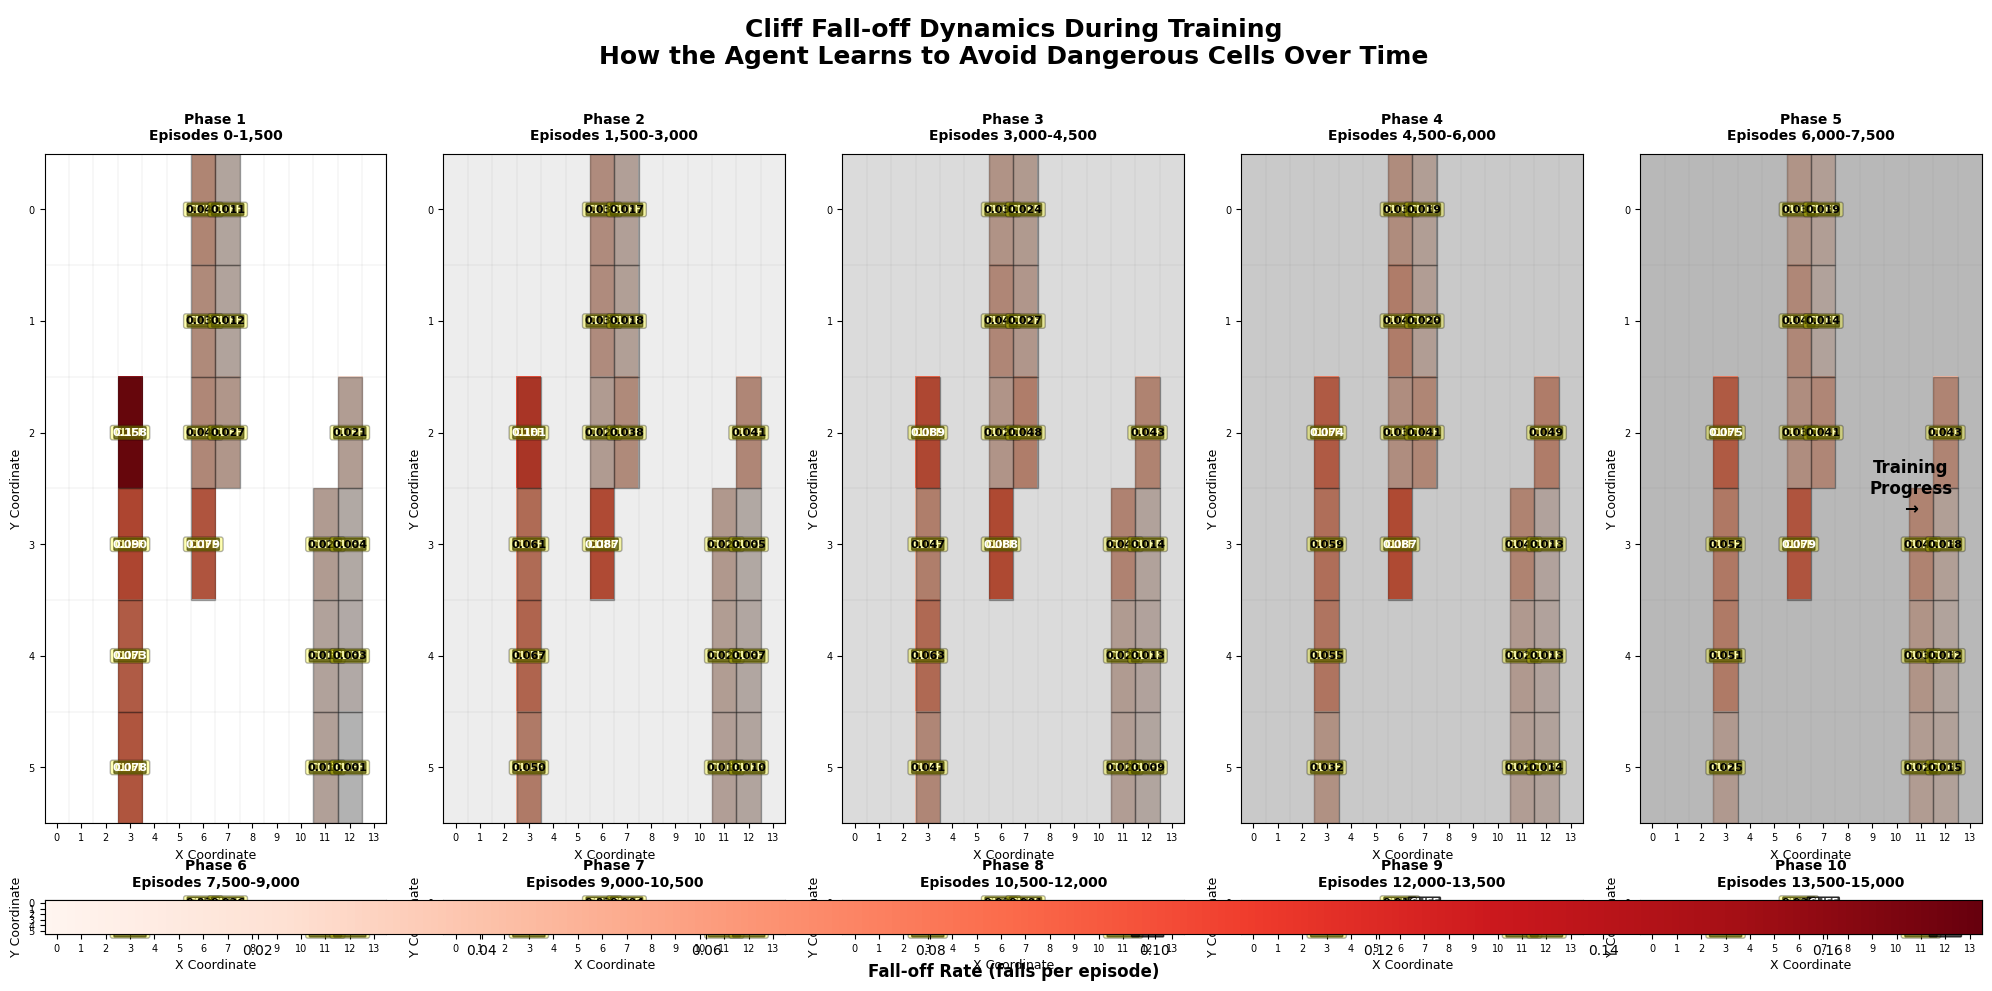


📊 CLIFF FALL-OFF DYNAMICS ANALYSIS
Phase  1: 1096 falls (73.07%) ██████████████░░░░░░
Phase  2: 995 falls (66.33%) █████████████░░░░░░░
Phase  3: 1040 falls (69.33%) █████████████░░░░░░░
Phase  4: 1027 falls (68.47%) █████████████░░░░░░░
Phase  5: 965 falls (64.33%) ████████████░░░░░░░░
Phase  6: 959 falls (63.93%) ████████████░░░░░░░░
Phase  7: 615 falls (41.00%) ████████░░░░░░░░░░░░
Phase  8: 504 falls (33.60%) ██████░░░░░░░░░░░░░░
Phase  9: 461 falls (30.73%) ██████░░░░░░░░░░░░░░
Phase 10: 505 falls (33.67%) ██████░░░░░░░░░░░░░░

📈 Overall Statistics:
   Total falls: 8,167
   Overall fall rate: 54.45%
   Training episodes: 15,000

⚠️  Most Dangerous Cliff Cells:
   1. Cell (np.int64(2), np.int64(3)): 1034 falls (6.89%) - 🔥 HIGH
   2. Cell (np.int64(3), np.int64(6)): 1032 falls (6.88%) - 🔥 HIGH
   3. Cell (np.int64(3), np.int64(3)): 696 falls (4.64%) - 🔥 HIGH
   4. Cell (np.int64(4), np.int64(3)): 657 falls (4.38%) - 🔥 HIGH
   5. Cell (np.int64(1), np.int64(6)): 657 falls (4.38%) - 

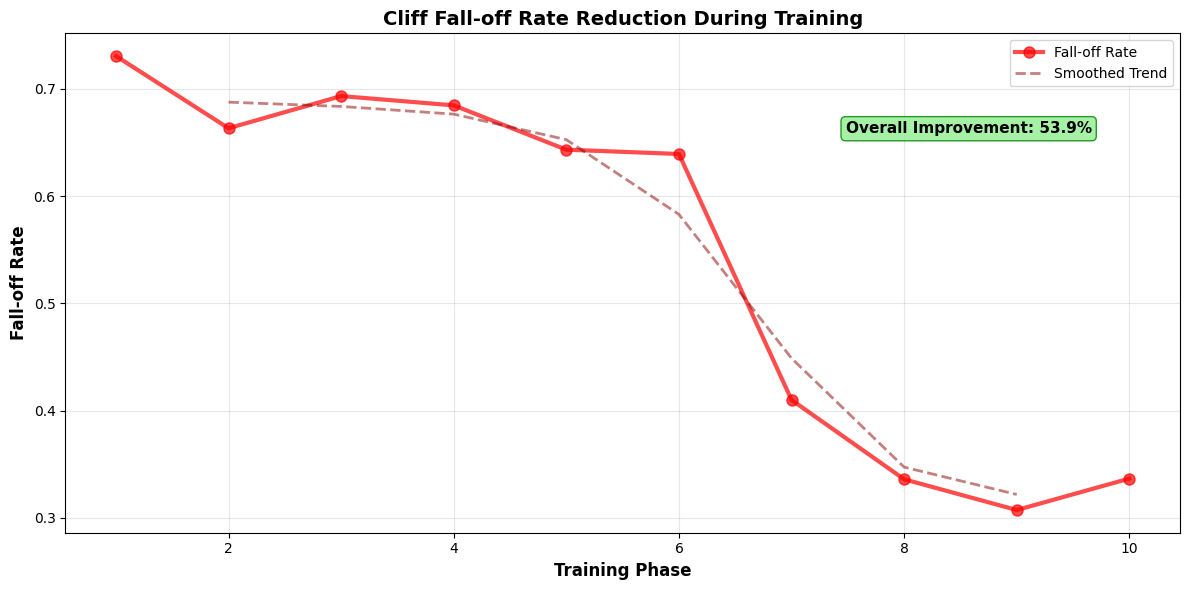


Evaluating trained agent...
Evaluation success rate: 1.000


In [6]:
def visualize(q_table, env):
    """Visualize the learned policy and value function."""
    v_table = {}
    policy = {}
    
    for state, action_values in q_table.items():
        # Value function: max Q-value for the state
        v_table[state] = max(action_values.values())
        # Policy: action with highest Q-value
        max_value = max(action_values.values())
        best_actions = [action for action, value in action_values.items() if value == max_value]
        policy[state] = best_actions[0]  # Take first best action if multiple
    
    print(f"State space size: {len(q_table)}")
    
    # Print top 20 state values
    print("\nTop 20 states by value:")
    sorted_states = sorted(v_table.items(), key=lambda x: x[1], reverse=True)[:20]
    for state, value in sorted_states:
        print(f"State {state}: Value = {value:.2f}, Policy = {policy[state]}")
    
    return v_table, policy

def analyze_cliff_fall_dynamics(cliff_fall_records, num_episodes, env):
    """Analyze cliff fall rates over training phases."""
    num_phases = 10
    episodes_per_phase = num_episodes // num_phases
    
    # Initialize cliff cell positions from environment
    cliff_cells = []
    for region in env.danger_region:
        A, B = region
        for row in range(A[0], B[0] + 1):
            cliff_cells.append((row, A[1]))
    
    # Create heatmap data for each phase
    heatmap_data = np.zeros((env.world_height, env.world_width, num_phases))
    
    for phase in range(num_phases):
        start_episode = phase * episodes_per_phase
        end_episode = (phase + 1) * episodes_per_phase
        
        # Count falls per cliff cell in this phase
        phase_falls = defaultdict(int)
        phase_total_episodes = 0
        
        for episode in range(start_episode, min(end_episode, len(cliff_fall_records))):
            episode_falls = cliff_fall_records[episode]
            phase_total_episodes += 1
            
            for cliff_pos in episode_falls:
                phase_falls[cliff_pos] += 1
        
        # Calculate fall rates
        for cliff_pos in cliff_cells:
            fall_rate = phase_falls[cliff_pos] / phase_total_episodes if phase_total_episodes > 0 else 0
            heatmap_data[cliff_pos[0], cliff_pos[1], phase] = fall_rate
    
    # Plot heatmaps
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for phase in range(num_phases):
        ax = axes[phase]
        sns.heatmap(heatmap_data[:, :, phase], ax=ax, cmap='Reds', 
                   cbar=True, vmin=0, vmax=0.5)
        ax.set_title(f'Phase {phase + 1}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    
    plt.tight_layout()
    plt.suptitle('Cliff Fall Rates During Training Phases', y=1.02)
    plt.show()
    
    return heatmap_data

def visualize_enhanced_policy_and_values(agent, env, num_top_states=25):
    """Create comprehensive policy and value function visualizations."""
    # Calculate value table and policy
    v_table = {}
    policy_table = {}
    
    for state, action_values in agent.q_table.items():
        v_table[state] = max(action_values.values())
        policy_table[state] = max(action_values.items(), key=lambda x: x[1])[0]
    
    # Create visualization for key states
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Top states by value
    top_states = sorted(v_table.items(), key=lambda x: x[1], reverse=True)[:num_top_states]
    
    state_indices = range(len(top_states))
    values = [val for _, val in top_states]
    state_labels = [f'({s[0]},{s[1]})\n({s[2]},{s[3]})' for s, _ in top_states]
    
    bars = ax1.bar(state_indices, values, color='skyblue', alpha=0.7)
    ax1.set_xlabel('State (Agent Pos, Box Pos)', fontsize=12)
    ax1.set_ylabel('State Value', fontsize=12)
    ax1.set_title(f'Top {num_top_states} States by Value', fontsize=14, fontweight='bold')
    ax1.set_xticks(state_indices)
    ax1.set_xticklabels(state_labels, rotation=45, ha='right')
    
    # Add value annotations on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                f'{value:.1f}', ha='center', va='bottom', rotation=0, fontsize=8)
    
    # Plot 2: Policy distribution
    action_names = ['Up', 'Down', 'Left', 'Right']
    action_counts = {action: 0 for action in agent.action_space}
    
    for state, action in policy_table.items():
        action_counts[action] += 1
    
    total_states = len(policy_table)
    action_percentages = [action_counts[action]/total_states * 100 
                         for action in agent.action_space]
    
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    wedges, texts, autotexts = ax2.pie(action_percentages, labels=action_names, 
                                      colors=colors, autopct='%1.1f%%', startangle=90)
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax2.set_title('Policy Action Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("="*80)
    print("POLICY AND VALUE ANALYSIS")
    print("="*80)
    print(f"Total states: {len(v_table):,}")
    print(f"Average state value: {np.mean(list(v_table.values())):.2f}")
    print(f"Maximum state value: {max(v_table.values()):.2f}")
    print(f"Minimum state value: {min(v_table.values()):.2f}")
    print("\nTop 10 Most Valuable States:")
    print("Rank | State (Agent, Box) | Value | Best Action")
    print("-" * 55)
    
    for i, (state, value) in enumerate(top_states[:10]):
        action_name = ['Up', 'Down', 'Left', 'Right'][policy_table[state]-1]
        print(f"{i+1:4} | ({state[0]:2},{state[1]:2}) ({state[2]:2},{state[3]:2}) | {value:6.1f} | {action_name}")
    
    return v_table, policy_table


def plot_cliff_fall_trend(phase_stats):
    """Plot the trend of cliff falls over training phases."""
    if not phase_stats:
        print("No phase statistics available for trend analysis")
        return
        
    phases = [stat[0] for stat in phase_stats]
    fall_rates = [stat[2] for stat in phase_stats]
    
    plt.figure(figsize=(12, 6))
    
    # Main trend line
    plt.plot(phases, fall_rates, 'o-', linewidth=3, markersize=8, 
             color='red', alpha=0.7, label='Fall-off Rate')
    
    # Add confidence band (simple moving average)
    if len(fall_rates) > 2:
        smoothed = np.convolve(fall_rates, [0.25, 0.5, 0.25], mode='valid')
        plt.plot(phases[1:-1], smoothed, '--', color='darkred', alpha=0.5, 
                linewidth=2, label='Smoothed Trend')
    
    plt.xlabel('Training Phase', fontsize=12, fontweight='bold')
    plt.ylabel('Fall-off Rate', fontsize=12, fontweight='bold')
    plt.title('Cliff Fall-off Rate Reduction During Training', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add improvement annotation
    if len(fall_rates) >= 2:
        improvement = (fall_rates[0] - fall_rates[-1]) / fall_rates[0] * 100
        plt.annotate(f'Overall Improvement: {improvement:.1f}%', 
                    xy=(0.7, 0.8), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="green", alpha=0.8),
                    fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


def plot_cliff_fall_dynamics_heatmap(agent, env):
    """Create professional cliff fall-off heatmap visualization with proper layout."""
    num_phases = 10
    episodes_per_phase = agent.num_episodes // num_phases
    
    # Create base grid with cliff positions
    cliff_grid = np.zeros((env.world_height, env.world_width))
    for region in env.danger_region:
        A, B = region
        for i in range(A[0], B[0] + 1):
            cliff_grid[i, A[1]] = 1  # Mark cliff cells
    
    # Create the visualization with better layout management
    fig = plt.figure(figsize=(25, 12))
    gs = plt.GridSpec(3, 10, figure=fig, height_ratios=[0.1, 1, 0.05])
    
    # Main title
    title_ax = fig.add_subplot(gs[0, :])
    title_ax.text(0.5, 0.5, 'Cliff Fall-off Dynamics During Training\nHow the Agent Learns to Avoid Dangerous Cells Over Time', 
                 ha='center', va='center', fontsize=18, fontweight='bold')
    title_ax.axis('off')
    
    # Create subplots for each phase
    axes = []
    for phase in range(num_phases):
        row = 1 + phase // 5
        col = phase % 5
        ax = fig.add_subplot(gs[row, col*2:col*2+2])
        axes.append(ax)
    
    # Custom colormap for fall rates
    cmap = plt.cm.Reds
    cmap.set_under('white')  # No falls appear white
    
    max_fall_rate = 0
    for phase in range(num_phases):
        phase_falls = agent.cliff_fall_records[phase]
        for count in phase_falls.values():
            rate = count / episodes_per_phase
            if rate > max_fall_rate:
                max_fall_rate = rate
    
    vmax = max(0.1, max_fall_rate * 1.1)  # Add some padding
    
    # Collect statistics for analysis
    all_phase_stats = []
    
    for phase, ax in enumerate(axes):
        # Create phase grid
        phase_grid = np.full((env.world_height, env.world_width), np.nan)
        
        # Calculate fall rates for this phase
        total_episodes_in_phase = episodes_per_phase
        phase_falls = agent.cliff_fall_records[phase]
        
        for (row, col), count in phase_falls.items():
            phase_grid[row, col] = count / total_episodes_in_phase
        
        # Create heatmap
        im = ax.imshow(phase_grid, cmap=cmap, vmin=0.001, vmax=vmax, 
                      interpolation='nearest', aspect='auto')
        
        # Mark cliff positions
        for i in range(env.world_height):
            for j in range(env.world_width):
                if cliff_grid[i, j] == 1:
                    # Add cliff cell background
                    ax.add_patch(Rectangle((j-0.5, i-0.5), 1, 1, 
                                         fill=True, color='black', alpha=0.3))
                    ax.text(j, i, 'CLIFF', ha='center', va='center', 
                           fontweight='bold', fontsize=7, color='white',
                           bbox=dict(boxstyle="round,pad=0.1", facecolor='black', alpha=0.7))
                
                # Add fall rate annotations
                if not np.isnan(phase_grid[i, j]) and phase_grid[i, j] > 0:
                    rate = phase_grid[i, j]
                    color = 'white' if rate > vmax * 0.4 else 'black'
                    ax.text(j, i, f'{rate:.3f}', ha='center', va='center', 
                           fontweight='bold', fontsize=8, color=color,
                           bbox=dict(boxstyle="round,pad=0.2", facecolor='yellow', alpha=0.3))
        
        # Set labels and title
        ax.set_xlabel('X Coordinate', fontsize=9)
        ax.set_ylabel('Y Coordinate', fontsize=9)
        start_ep = phase * episodes_per_phase
        end_ep = (phase + 1) * episodes_per_phase
        
        # Color code phases by training progress
        color_intensity = 1.0 - (phase / num_phases) * 0.7  # Darker for later phases
        ax.set_facecolor((color_intensity, color_intensity, color_intensity))
        
        ax.set_title(f'Phase {phase+1}\nEpisodes {start_ep:,}-{end_ep:,}', 
                    fontsize=10, fontweight='bold', pad=10)
        
        # Add grid
        ax.set_xticks(np.arange(-0.5, env.world_width, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, env.world_height, 1), minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.3, alpha=0.3)
        ax.tick_params(which="minor", size=0)
        
        # Set proper ticks
        ax.set_xticks(range(env.world_width))
        ax.set_yticks(range(env.world_height))
        ax.set_xticklabels(range(env.world_width), fontsize=7)
        ax.set_yticklabels(range(env.world_height), fontsize=7)
        
        # Store phase statistics
        phase_fall_count = sum(phase_falls.values())
        phase_fall_rate = phase_fall_count / episodes_per_phase
        all_phase_stats.append((phase + 1, phase_fall_count, phase_fall_rate))
    
    # Add colorbar at the bottom
    cbar_ax = fig.add_subplot(gs[2, :])
    cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Fall-off Rate (falls per episode)', fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)
    
    # Add phase progression annotation
    progression_ax = fig.add_subplot(gs[1, 9:])
    progression_ax.text(0.5, 0.5, 'Training\nProgress\n→', 
                       ha='center', va='center', fontsize=12, fontweight='bold',
                       rotation=0, transform=progression_ax.transAxes)
    progression_ax.axis('off')
    
    plt.subplots_adjust(wspace=0.4, hspace=0.3)
    plt.show()
    
    # Enhanced statistical analysis
    print("\n" + "="*80)
    print("📊 CLIFF FALL-OFF DYNAMICS ANALYSIS")
    print("="*80)
    
    total_falls = 0
    for phase_num, fall_count, fall_rate in all_phase_stats:
        total_falls += fall_count
        
        # Progress indicator
        progress_bar = "█" * int(fall_rate * 20) + "░" * (20 - int(fall_rate * 20))
        print(f"Phase {phase_num:2}: {fall_count:3} falls ({fall_rate:6.2%}) {progress_bar}")
    
    overall_fall_rate = total_falls / agent.num_episodes
    
    print(f"\n📈 Overall Statistics:")
    print(f"   Total falls: {total_falls:,}")
    print(f"   Overall fall rate: {overall_fall_rate:.2%}")
    print(f"   Training episodes: {agent.num_episodes:,}")
    
    # Identify most dangerous cliff cells
    cell_danger = defaultdict(int)
    for phase in range(num_phases):
        for cell, count in agent.cliff_fall_records[phase].items():
            cell_danger[cell] += count
    
    if cell_danger:
        print(f"\n⚠️  Most Dangerous Cliff Cells:")
        sorted_danger = sorted(cell_danger.items(), key=lambda x: x[1], reverse=True)[:5]
        for i, (cell, count) in enumerate(sorted_danger):
            danger_level = "🔥 HIGH" if count > episodes_per_phase * 0.1 else "⚠️  MEDIUM" if count > episodes_per_phase * 0.05 else "ℹ️  LOW"
            print(f"   {i+1}. Cell {cell}: {count} falls ({count/agent.num_episodes:.2%}) - {danger_level}")
    
    # Learning progress analysis
    if len(all_phase_stats) >= 8:
        early_phase_falls = sum(stats[1] for stats in all_phase_stats[:3])  # First 3 phases
        late_phase_falls = sum(stats[1] for stats in all_phase_stats[7:])   # Last 3 phases
        
        if early_phase_falls > 0:
            improvement = (early_phase_falls - late_phase_falls) / early_phase_falls * 100
            print(f"\n🎯 Learning Progress: {improvement:.1f}% reduction in falls from early to late phases")
        else:
            print(f"\n🎯 Learning Progress: No falls in early phases - excellent start!")
    
    return all_phase_stats



print("Training Q-learning agent...")
env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=15000, epsilon=0.1, alpha=0.1, gamma=0.99)
rewards = agent.learn()

# Plot learning progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rewards, alpha=0.3, label='Raw')
# Smooth the rewards for better visualization
window_size = 100
smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size-1, len(rewards)), smoothed_rewards, label=f'Smoothed (window={window_size})', color='red')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Progress')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
# Plot success rate over time
success_rates = []
window = 500
for i in range(window, len(rewards)):
    success_rate = np.sum(np.array(rewards[i-window:i]) > 0) / window
    success_rates.append(success_rate)

plt.plot(range(window, len(rewards)), success_rates)
plt.xlabel('Episode')
plt.ylabel('Success Rate')
plt.title(f'Success Rate (rolling window={window})')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate final performance
final_rewards = np.array(rewards[-2000:])
success_rate = np.sum(final_rewards > 0) / len(final_rewards)
print(f"Final success rate: {success_rate:.3f}")

# Visualize learned policy
print("\nVisualizing learned policy...")
v_table, policy = visualize(agent.q_table, env)

# Analyze cliff fall dynamics
print("\nAnalyzing cliff fall dynamics...")
heatmap_data = analyze_cliff_fall_dynamics(agent.cliff_fall_records, agent.num_episodes, env)


# Policy and value visualization
print("\n🎯 Analyzing learned policy and values...")
v_table, policy_table = visualize_enhanced_policy_and_values(agent, env)

# Cliff fall-off dynamics
print("\n🔥 Analyzing cliff fall-off dynamics...")
phase_stats = plot_cliff_fall_dynamics_heatmap(agent, env)

# Additional trend analysis
print("\n📉 Plotting fall-off trend...")
plot_cliff_fall_trend(phase_stats)

# Evaluate agent without exploration
print("\nEvaluating trained agent...")
env_eval = CliffBoxGridWorld()
total_runs = 1000
success_count = 0

for i in range(total_runs):
    state = env_eval.reset()
    done = False
    
    while not done:
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = env_eval.step(action)
        state = next_state
    
    if reward > 0:  # Success if final reward indicates goal reached
        success_count += 1

print(f"Evaluation success rate: {success_count/total_runs:.3f}")

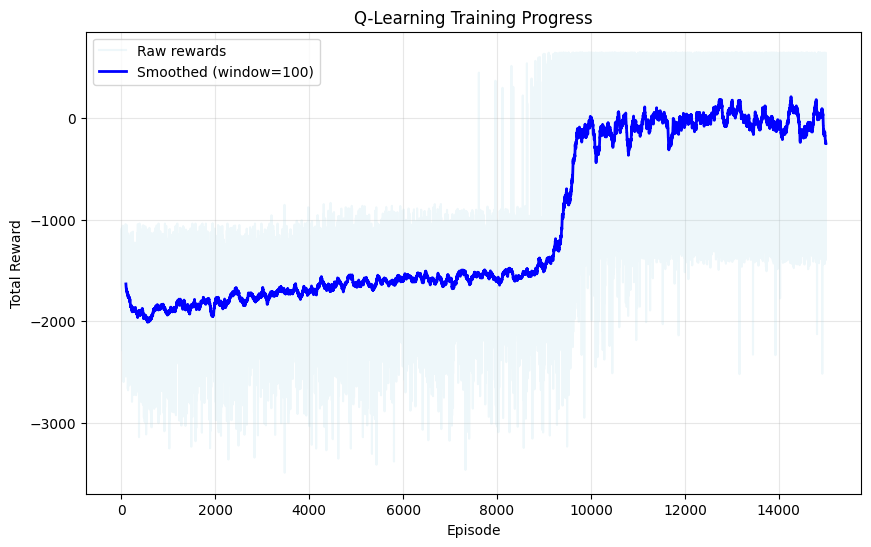

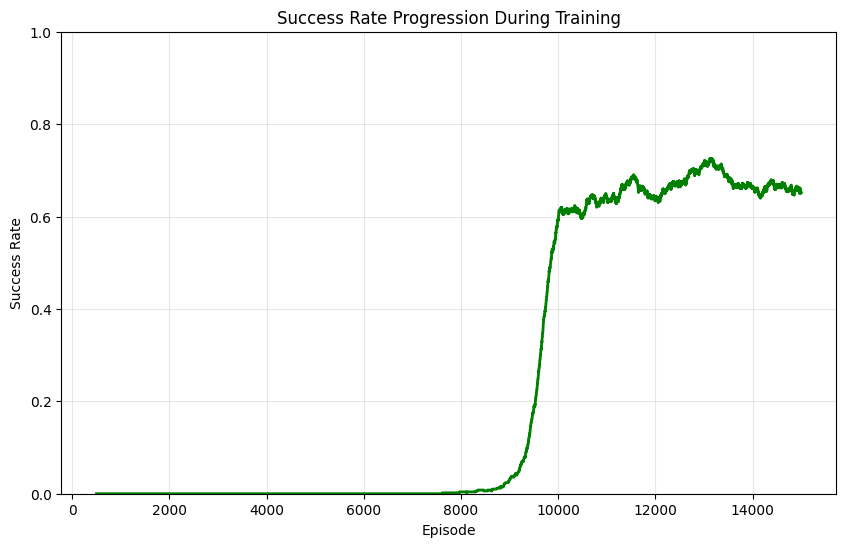

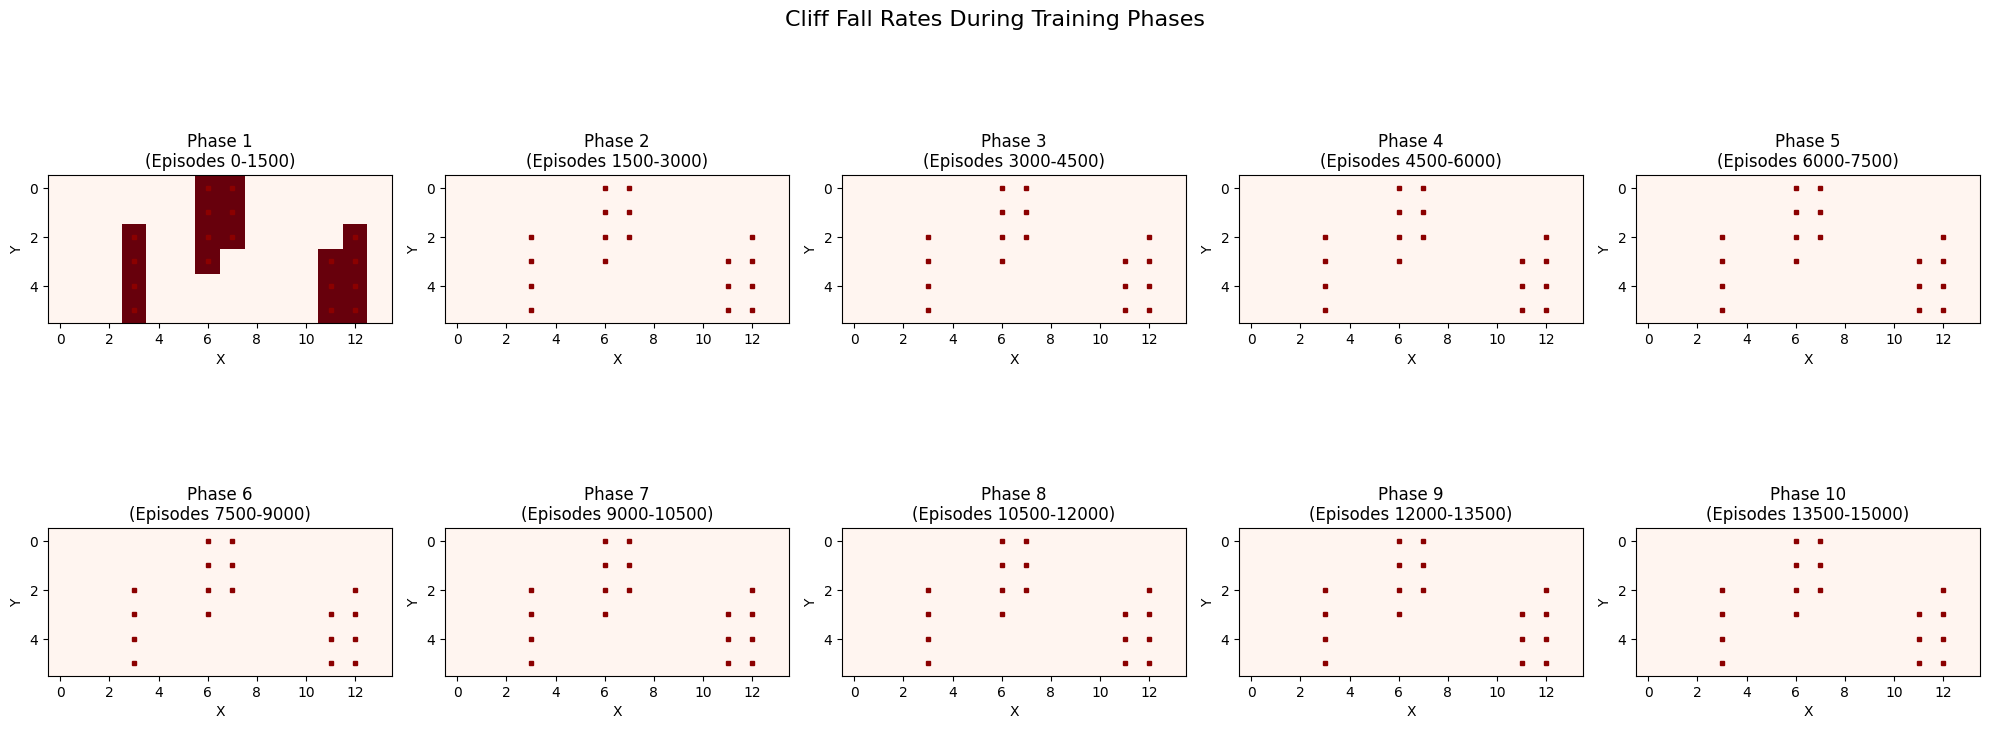

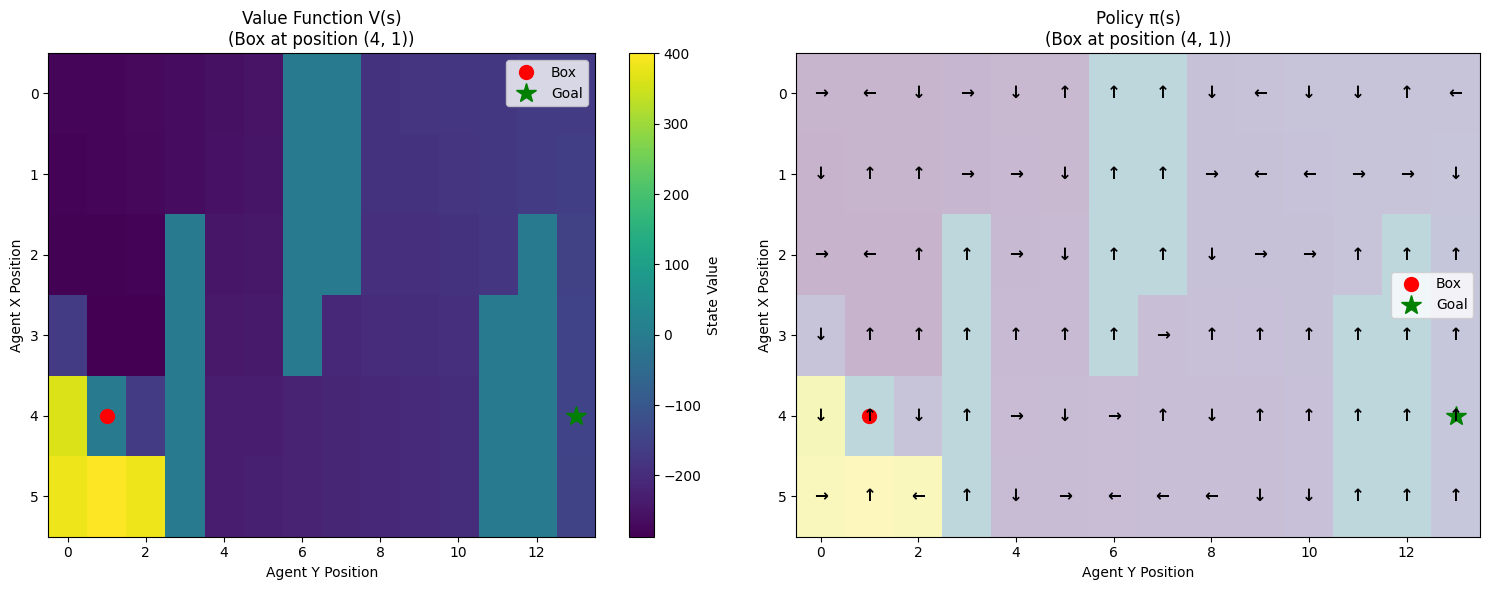

Success in 36 steps!


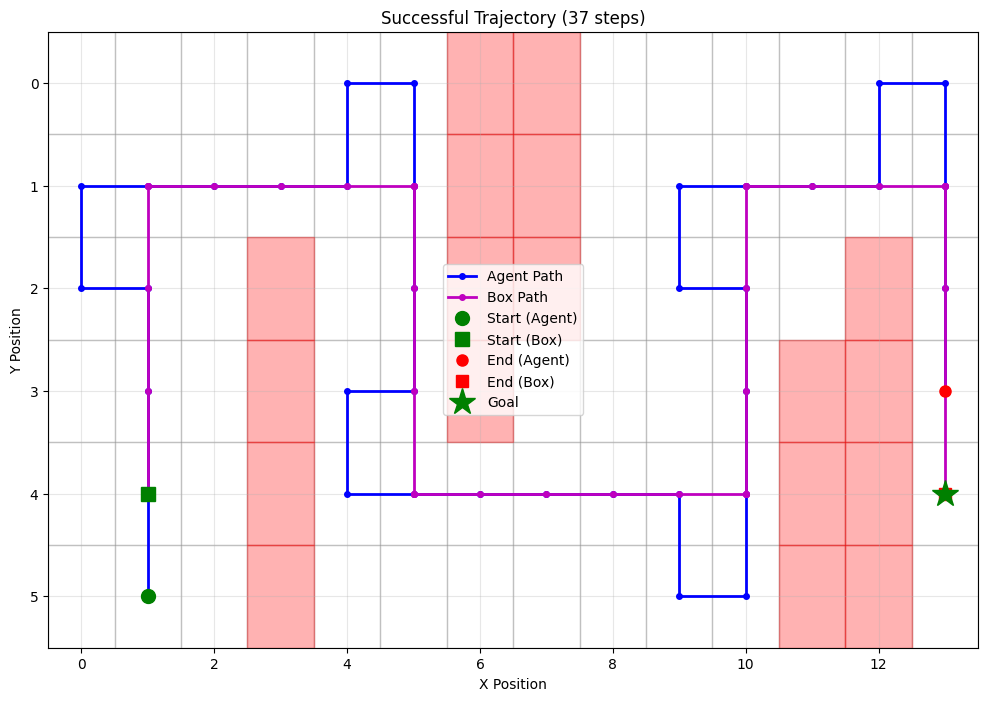

In [ ]:
# Learning curve with smoothing - THIS IS ALREADY DYNAMIC
plt.figure(figsize=(10, 6))
window = 100
smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.plot(rewards, alpha=0.2, color='lightblue', label='Raw rewards')
plt.plot(range(window-1, len(rewards)), smoothed_rewards, 'b-', 
         label=f'Smoothed (window={window})', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Success rate progression - THIS IS ALREADY DYNAMIC
plt.figure(figsize=(10, 6))
window = 500
success_rates = []
for i in range(window, len(rewards)):
    success_rate = np.sum(np.array(rewards[i-window:i]) > 0) / window
    success_rates.append(success_rate)

plt.plot(range(window, len(rewards)), success_rates, 'g-', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Success Rate')
plt.title('Success Rate Progression During Training')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()


def create_cliff_fall_heatmaps(cliff_fall_records, num_episodes, env):
    """Create the required cliff fall rate heatmaps across training phases"""
    num_phases = 10
    episodes_per_phase = num_episodes // num_phases
    
    # Get all cliff cell positions
    cliff_cells = []
    for region in env.danger_region:
        A, B = region
        for row in range(A[0], B[0] + 1):
            cliff_cells.append((row, A[1]))
    
    # Create heatmap data
    heatmap_data = np.zeros((env.world_height, env.world_width, num_phases))
    
    for phase in range(num_phases):
        start_ep = phase * episodes_per_phase
        end_ep = (phase + 1) * episodes_per_phase
        phase_falls = defaultdict(int)
        phase_total = 0
        
        for episode in range(start_ep, min(end_ep, len(cliff_fall_records))):
            episode_falls = cliff_fall_records[episode]
            phase_total += 1
            for cliff_pos in episode_falls:
                phase_falls[cliff_pos] += 1
        
        # Calculate fall rates
        for cliff_pos in cliff_cells:
            fall_rate = phase_falls[cliff_pos] / phase_total if phase_total > 0 else 0
            heatmap_data[cliff_pos[0], cliff_pos[1], phase] = fall_rate
    
    # Plot heatmaps
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for phase in range(num_phases):
        ax = axes[phase]
        im = ax.imshow(heatmap_data[:, :, phase], cmap='Reds', vmin=0, vmax=0.3)
        ax.set_title(f'Phase {phase+1}\n(Episodes {phase*episodes_per_phase}-{(phase+1)*episodes_per_phase})')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        
        # Mark cliff positions
        for cliff_pos in cliff_cells:
            ax.plot(cliff_pos[1], cliff_pos[0], 's', color='darkred', markersize=3)
    
    plt.tight_layout()
    plt.suptitle('Cliff Fall Rates During Training Phases', y=1.02, fontsize=16)
    plt.show()
    
    return heatmap_data

# Generate the required cliff fall analysis
cliff_heatmaps = create_cliff_fall_heatmaps(agent.cliff_fall_records, agent.num_episodes, env)

def visualize_value_function(agent, env):
    """Visualize the value function for key states"""
    # Create value function for initial state (box at (4,1))
    box_pos = (4, 1)  # Initial box position
    value_map = np.zeros((env.world_height, env.world_width))
    policy_map = np.full((env.world_height, env.world_width), '', dtype=object)
    
    action_symbols = {1: '↑', 2: '↓', 3: '←', 4: '→'}
    
    for agent_x in range(env.world_height):
        for agent_y in range(env.world_width):
            state = (agent_x, agent_y, box_pos[0], box_pos[1])
            if state in agent.q_table:
                value_map[agent_x, agent_y] = max(agent.q_table[state].values())
                best_action = max(agent.q_table[state].items(), key=lambda x: x[1])[0]
                policy_map[agent_x, agent_y] = action_symbols[best_action]
    
    # Plot value function
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Value function heatmap
    im = ax1.imshow(value_map, cmap='viridis', aspect='auto')
    ax1.set_title(f'Value Function V(s)\n(Box at position {box_pos})')
    ax1.set_xlabel('Agent Y Position')
    ax1.set_ylabel('Agent X Position')
    plt.colorbar(im, ax=ax1, label='State Value')
    
    # Mark special positions
    ax1.plot(box_pos[1], box_pos[0], 'ro', markersize=10, label='Box')
    ax1.plot(env.goal_pos[1], env.goal_pos[0], 'g*', markersize=15, label='Goal')
    ax1.legend()
    
    # Policy visualization
    ax2.imshow(value_map, cmap='viridis', aspect='auto', alpha=0.3)
    for i in range(env.world_height):
        for j in range(env.world_width):
            if policy_map[i, j] != '':
                ax2.text(j, i, policy_map[i, j], ha='center', va='center', 
                        fontsize=12, fontweight='bold', color='black')
    
    ax2.set_title(f'Policy π(s)\n(Box at position {box_pos})')
    ax2.set_xlabel('Agent Y Position')
    ax2.set_ylabel('Agent X Position')
    ax2.plot(box_pos[1], box_pos[0], 'ro', markersize=10, label='Box')
    ax2.plot(env.goal_pos[1], env.goal_pos[0], 'g*', markersize=15, label='Goal')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

visualize_value_function(agent, env)

def plot_successful_trajectory(agent, env):
    """Plot a successful trajectory"""
    # Run until success
    test_env = CliffBoxGridWorld(render=False)
    state = test_env.reset()
    trajectory = []
    
    for step in range(100):  # Increased step limit
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = test_env.step(action)
        
        trajectory.append({
            'step': step,
            'agent_pos': test_env.agent_pos.copy(),
            'box_pos': test_env.box_pos.copy(),
            'action': action,
            'reward': reward
        })
        
        state = next_state
        if all(test_env.box_pos == test_env.goal_pos):
            print(f"Success in {step} steps!")
            break
        if done:
            break
    
    # Plot trajectory
    plt.figure(figsize=(12, 8))
    
    # Create grid
    for i in range(env.world_height):
        for j in range(env.world_width):
            plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                                            facecolor='white', edgecolor='gray', alpha=0.3))
    
    # Mark dangerous regions
    for region in env.danger_region:
        A, B = region
        for row in range(A[0], B[0] + 1):
            plt.gca().add_patch(plt.Rectangle((A[1]-0.5, row-0.5), 1, 1, 
                                            color='red', alpha=0.3))
    
    # Plot trajectory
    agent_x = [pos['agent_pos'][1] for pos in trajectory]
    agent_y = [pos['agent_pos'][0] for pos in trajectory]
    box_x = [pos['box_pos'][1] for pos in trajectory]
    box_y = [pos['box_pos'][0] for pos in trajectory]
    
    plt.plot(agent_x, agent_y, 'bo-', linewidth=2, markersize=4, label='Agent Path')
    plt.plot(box_x, box_y, 'mo-', linewidth=2, markersize=4, label='Box Path')
    
    # Mark key positions
    plt.plot(agent_x[0], agent_y[0], 'go', markersize=10, label='Start (Agent)')
    plt.plot(box_x[0], box_y[0], 'gs', markersize=10, label='Start (Box)')
    plt.plot(agent_x[-1], agent_y[-1], 'ro', markersize=8, label='End (Agent)')
    plt.plot(box_x[-1], box_y[-1], 'rs', markersize=8, label='End (Box)')
    plt.plot(env.goal_pos[1], env.goal_pos[0], 'g*', markersize=20, label='Goal')
    
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Successful Trajectory ({len(trajectory)} steps)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(-0.5, env.world_width - 0.5)
    plt.ylim(-0.5, env.world_height - 0.5)
    plt.gca().invert_yaxis()
    plt.show()
    
    return trajectory

# Plot a successful trajectory
success_trajectory = plot_successful_trajectory(agent, env)




Evaluate the agent without exploration

In [81]:
env = CliffBoxGridWorld(render=True)
total_run = 1000
success = 0

for i in range(total_run):
    state = env.reset()
    done = False
    rewards = []
    
    while not done: 
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = env.step(action)
        state = next_state
        rewards.append(reward)
    if sum(rewards) > 0:
        success += 1
print(success/total_run)

1.0


Evaluate the agent with exploration and visualization

In [82]:
env = CliffBoxGridWorld(render=True)
state = env.reset()
env.print_world()
done = False
rewards = []

while not done: # Run until game terminated
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    state = next_state
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_' '_' 'x' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' '_' '_' '_' '_' 'x' 'x' '_']
 ['_' 'B' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' 'G']
 ['A' '_' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' '_']]
step: 1, state: (5, 1, 4, 1), actions: 4, reward: -14
Action: 4
[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_' '_' 'x' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' '_' '_' '_' '_' 'x' 'x' '_']
 ['_' 'B' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' 'G']
 ['_' 'A' '_' 'x' '_' '_' '_' '_' '_' '_' '_' 'x' 'x' '_']]
step: 2, state: (4, 1, 3, 1), actions: 1, reward: -15
Action: 1
[['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'x' 'x' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'x' '_' '_' 'x' 'x' '_' '_' '_